## Pytorch

Obtendremos los datos de la siguiente página.

https://archive.ics.uci.edu/ml/machine-learning-databases/poker/

Solo se usará el archivo **poker-hand-testing.data** el cual dividiremos en los conjuntos de entrenamiento y validación.

Para instalar Pytorch puedes tu sistema operativo, tu instalador de paquetes de python y tus versiones, estaremos usando la versión 1.7.0 de pytorch, si tienes CUDA, también selecciona tu versión, en otro caso, 
puedes elegir None.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
#Definimos el dispositivo que se usará.
device = torch.device('cpu')

In [4]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
#Esta funcion nos ayudara a tener una matriz en donde la columna distinta de cero es
#nuestra etiqueta
def makeY(etiquetasEntrenamiento):
    Y=[]
    for i in range(len(etiquetasEntrenamiento)):
        y=np.zeros(10)
        y[int(etiquetasEntrenamiento[i])]=1
        Y.append(y)
    Y=np.array(Y)    
    return Y    

In [6]:
def get_data(path):
    '''
    Función para obtener las matrices de entrenamiento y de validación
    a partir de los datos que se encuentran en el archivo que se define en 
    el parámetro path.
    '''
    #Importamos nuestros datos
    datos = np.loadtxt(open(data_path), delimiter=",")
    #Revolvemos los datos aleatoriamente y escogemo el 70 porciento
    #de los datos para nuestar matriz de entrenamiento con ayuda de sklearn
    datos_train,datos_test= train_test_split(datos, test_size=0.30, random_state=1)
    #Separamos los datos de las salidas esperadas
    x_train=datos_train[:,:10]
    y_train=datos_train[:,10:11]
    x_test=datos_test[:,:10]
    y_test=datos_test[:,10:11]
    y_train=makeY(y_train)
    y_test=makeY(y_test)
    return x_train,y_train,x_test,y_test

In [7]:
data_path ='./poker-hand-testing.data'
## Define una función para obtener los datos, revuelvelos 
## aleatoriamente y dividelos en los conjuntos de validación y 
## de entrenamiento.
X_train,Y_train,X_val,Y_val = get_data(data_path)

Usaremos la biblioteca nn de pytorch para definir nuestro modelo de red neuronal, puedes 
ver los tipos de capas, funciones de activación y funciones de error con las que 
disponemos viendo la documentación de pytorch. Busque la definición de 

https://pytorch.org/docs/stable/nn.html

In [8]:
class Poker(nn.Module):
    def __init__(self,input_size,hidden,output_size):
        '''
        Define las caracteristicas de una red completamente conectada 
        de tres capas, recibe la cantidad de elementos de entrada, el 
        número de capas ocultas y el número de elementos de salida. 
        Entre cada capa agrega una función de activación logistica.
        '''
        super(Poker,self).__init__()
        #Definimos nuestras capas que vamos a usar y nuestra funcion de activacion
        self.W1=nn.Linear(input_size,hidden)
        self.Log=nn.Sigmoid()
        self.W2=nn.Linear(hidden,output_size)

        
    def feed_forward(self,X):
        '''
        Define una función que de como resultado realizar la propagación
        hacia adelante de los elementos de X en la red definida.
        '''
        X=torch.from_numpy(X).to(torch.float32)
        Z1=self.W1(X)
        A1=self.Log(Z1)
        Z2=self.W2(A1)
        A2=self.Log(Z2)
        self.A2=A2
    
    def back_propagate(self,X,Y):
        '''
        Define una función que realice la propagación hacia atras usando 
        la función de error de entropia cruzada.
        '''
        Y=torch.from_numpy(Y).to(torch.float32)
        Entropia=torch.nn.CrossEntropyLoss()
        error=Entropia(X,Y)
        self.error=error
    def train(self,train_X,train_Y,optimizer,ciclos=100):
        '''
        Define una función de entrenamiento para la red, la cual utilice
        al conjunto de entrenamiento y el algoritmo de optimización que se 
        obtenga como parametro. Al finalizar los ciclos muestra la gráfica 
        del error.
        '''
        E=[]
        for i in range(ciclos):
            if optimizer==0:
                algoritmo=optim.SGD(RedPoker.parameters(), lr=0.01)
            if optimizer==1:
                algoritmo=optim.Adam(RedPoker.parameters(), lr=0.01)
            if optimizer==2:
                algoritmo=optim.Adagrad(RedPoker.parameters(), lr=0.01)
            self.feed_forward(train_X)
            self.back_propagate(self.A2,train_Y)
            algoritmo.zero_grad()
            self.error.backward()
            algoritmo.step()
            E.append(self.error.item())
        self.errores=E
        x = np.arange(ciclos)
        plt.title("Error")
        plt.xlabel("ciclo")
        plt.scatter(x, self.errores)  
    def confusion(self,test_X,test_Y):
        '''
        Muestra la matriz de confusión que presenta los valores actuales de
        la red, respecto al conjunto de datos que se decida usar.
        '''
        self.feed_forward(test_X)
        A2=self.A2.detach().numpy()
        pred_Y=np.zeros(A2.shape)
        pred_Y[A2>=0.5]=1
        
        numElemems = test_Y.shape[0] * test_Y.shape[1]
        prediccion = pred_Y.astype(bool)
        etiquetas = test_Y.astype(bool)
    
        matriz = np.zeros((2,2))
        TP = np.sum(np.logical_and(prediccion, etiquetas))
        matriz[0][0] = TP
    
        TN = np.logical_and(np.logical_not(prediccion), np.logical_not(etiquetas))
        matriz[1][1] = np.sum(TN)
    
        FP = np.logical_and(np.logical_not(etiquetas), prediccion)
        matriz[1][0] = np.sum(FP)
    
        FN = np.logical_and(etiquetas, np.logical_not(prediccion))
        matriz[0][1] = np.sum(FN)
    
        return matriz
        

Usando la misma definición de la red podemos modificar fácilmente los algoritmos de optimización que 
usamos para su entrenamiento. Prueba los siguientes algoritmos de optimización con tus mismos datos 
y con la misma cantidad de iteraciones.

Las definiciones de estos algorimos las puedes ver en la documentación de pytorch

https://pytorch.org/docs/stable/optim.html

## Algoritmo stochastic gradient descent

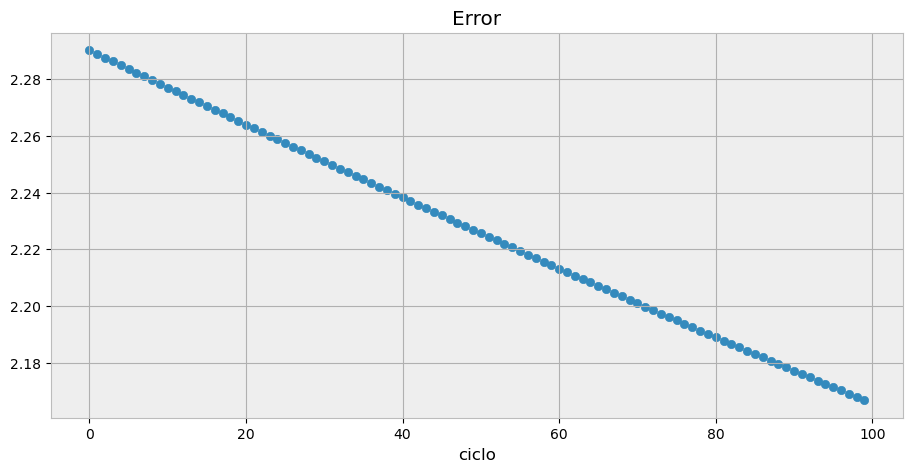

In [9]:
## Entrena una red utilizando el algoritmo de optimización de
## stochastic gradient descent y muestra la matriz de confusión
RedPoker=Poker(10,20,10)
RedPoker.train(X_train,Y_train,optimizer=0)

In [10]:
RedPoker.confusion(X_train,Y_train)

array([[ 693446.,    6554.],
       [2985693., 3314307.]])

In [11]:
RedPoker.confusion(X_val,Y_val)

array([[ 297233.,    2767.],
       [1280174., 1419826.]])

## Algoritmo Adam

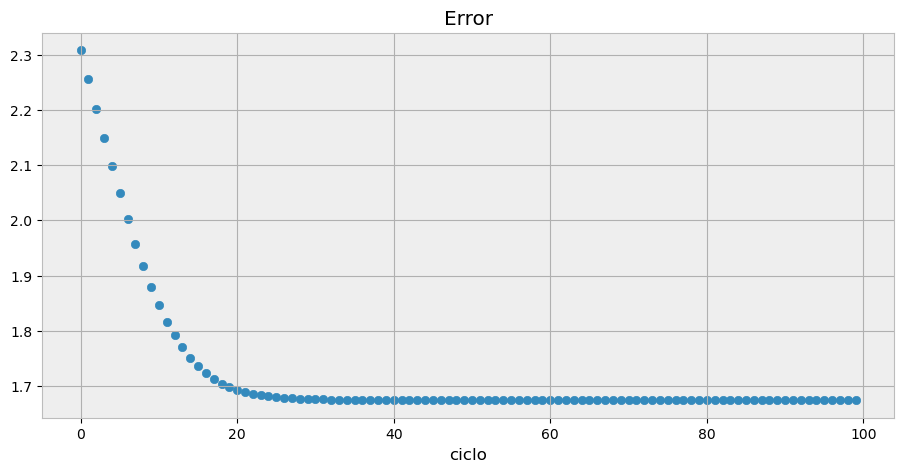

In [12]:
## Entrena una red utilizando el algoritmo de optimización Adam
## y muestra la matriz de confusión
RedPoker=Poker(10,20,10)
RedPoker.train(X_train,Y_train,optimizer=1)

In [13]:
RedPoker.confusion(X_train,Y_train)

array([[ 646613.,   53387.],
       [ 753387., 5546613.]])

In [14]:
RedPoker.confusion(X_val,Y_val)

array([[ 277094.,   22906.],
       [ 322906., 2377094.]])

## Algoritmo Adagrad

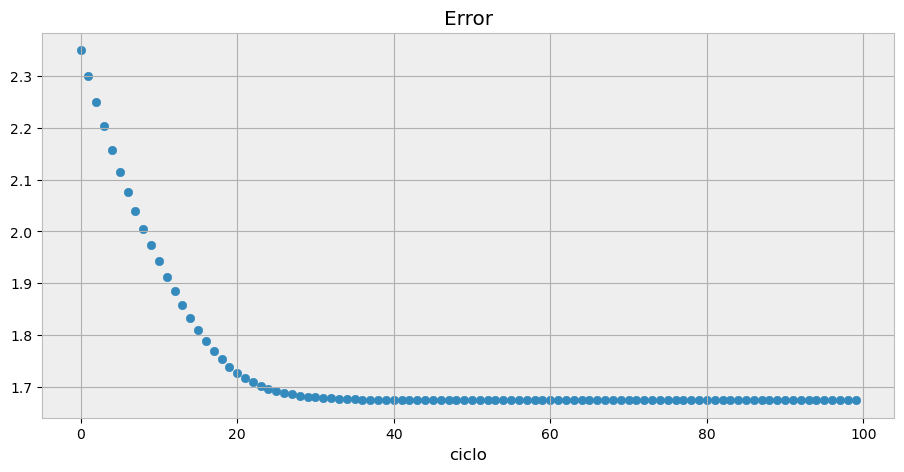

In [15]:
## Entrena una red utilizando el algoritmo de optmización Adagrad
## y muestra la matriz de confusión.
RedPoker=Poker(10,20,10)
RedPoker.train(X_train,Y_train,optimizer=2)

In [16]:
RedPoker.confusion(X_train,Y_train)

array([[ 646613.,   53387.],
       [ 753387., 5546613.]])

In [17]:
RedPoker.confusion(X_val,Y_val)

array([[ 277094.,   22906.],
       [ 322906., 2377094.]])

Gracias a las matrices de confusion podemos concluir que el mejor algortimo es el de Adam para el entrenamiento de estos datos

In [18]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()